In [15]:
%load_ext autoreload
%autoreload 2

import torch

from text3d2video.util import read_obj_with_uvs
from text3d2video.utilities.camera_placement import turntable_extrinsics
from pytorch3d.renderer import FoVPerspectiveCameras
from pathlib import Path

from matplotlib.cm import get_cmap
from text3d2video.rendering import render_texture
from text3d2video.util import sample_feature_map_ndc
from text3d2video.utilities.logging import H5Logger
import torchvision.transforms.functional as TF

from text3d2video.utilities.testing_utils import test_img
from text3d2video.rendering import render_rgb_uv_map
from text3d2video.utilities.ipython_utils import display_ims

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:

mesh_path = "data/meshes/cat_statue.obj"
device = "cuda"

# read mesh
mesh, verts_uvs, faces_uvs = read_obj_with_uvs(mesh_path, device=device)

n_frames = 10
dist = 6.5
angles = torch.linspace(0, 360, n_frames)
R, T = turntable_extrinsics(dists=dist, angles=angles)
frame_cams = FoVPerspectiveCameras(R=R, T=T, device="cuda", fov=10)
frame_meshes = mesh.extend(len(frame_cams))

In [17]:
from text3d2video.utilities.ipython_utils import display_vid
from text3d2video.utilities.video_util import pil_frames_to_clip


uv_frames = render_rgb_uv_map(frame_meshes, frame_cams, verts_uvs, faces_uvs)
display_vid(pil_frames_to_clip(uv_frames))

In [18]:
# precompute projections
from text3d2video.backprojection import project_visible_texels_to_camera

uv_res = 512
image_res = 512

projections = [
    project_visible_texels_to_camera(
        m, c, verts_uvs, faces_uvs, uv_res, raster_res=2000
    )
    for m, c in zip(frame_meshes, frame_cams)
]

# Visibility masks
Denote the area that is newly visible in each view

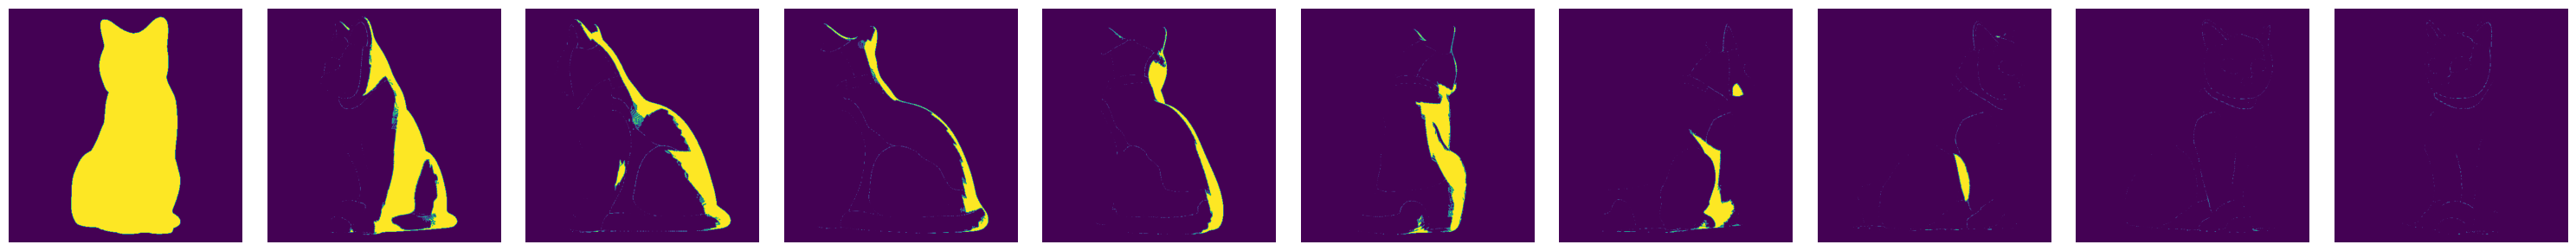

In [19]:
from text3d2video.rendering import compute_newly_visible_masks

newly_visible_masks = compute_newly_visible_masks(
    frame_cams, frame_meshes, projections, uv_res, image_res, verts_uvs, faces_uvs
)

display_ims([TF.to_pil_image(m) for m in newly_visible_masks])

# Quality Masks / Update Masks

Denotes the part of the image we want to update the uv space with

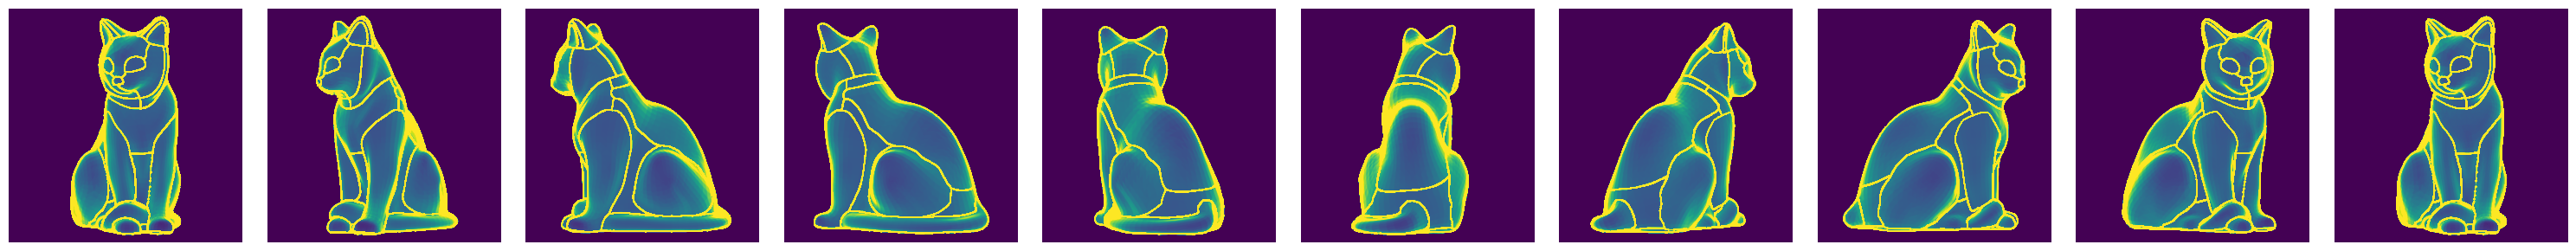

In [23]:
from text3d2video.rendering import compute_uv_jacobian_map


quality_maps = [
    compute_uv_jacobian_map(c, m, verts_uvs, faces_uvs)
    for c, m in zip(frame_cams, frame_meshes)
]
quality_maps = torch.stack(quality_maps)

display_ims(quality_maps, vmax=0.0003)

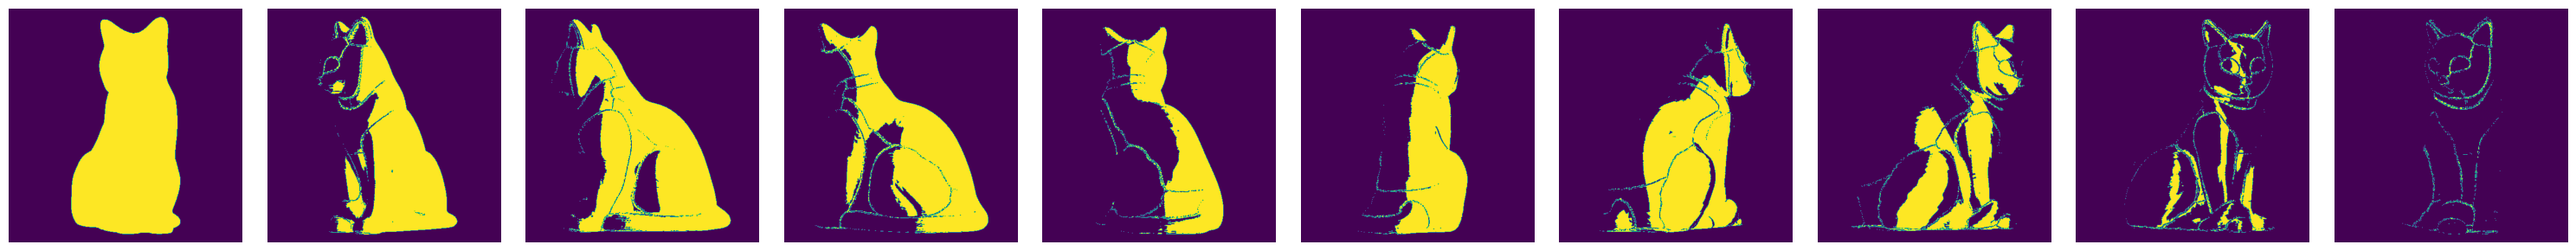

In [25]:
from text3d2video.rendering import compute_autoregressive_update_masks

better_quality_masks = compute_autoregressive_update_masks(
    frame_cams,
    frame_meshes,
    projections,
    quality_maps,
    uv_res,
    verts_uvs,
    faces_uvs,
    quality_factor=1.2,
)

display_ims(better_quality_masks)

In [26]:
logger = H5Logger(Path("data.h5"))
logger.delete_data()
logger.open_write()

uv_res = 512
image_res = 512
texture = torch.zeros(uv_res, uv_res, 3).cuda()

view_cmap = get_cmap("tab10")

view_colors = [view_cmap(i)[0:3] for i in range(n_frames)]
view_colors = torch.tensor(view_colors)
view_ims = [
    test_img(return_type="pt", color=c, resolution=image_res) for c in view_colors
]

for i in range(n_frames):
    mesh = frame_meshes[i]
    cam = frame_cams[i]
    projection = projections[i]

    # render partial texture map
    rendered_texture = render_texture(mesh, cam, texture, verts_uvs, faces_uvs)[0]
    logger.write("texture_render", rendered_texture, view_i=i)

    # newly visible mask
    newly_visible_mask = newly_visible_masks[i]

    # predict view
    color = view_colors[i]
    predicted_view = test_img(return_type="pt", color=color, resolution=image_res)

    # update_mask, masks out the part of predicted view we want to update with
    update_mask = better_quality_masks[i]

    # filter out texels that lie in the outside the update mask
    texels_in_mask = sample_feature_map_ndc(
        update_mask.unsqueeze(0).cuda(), projection.xys
    )
    uvs = projection.uvs[texels_in_mask[:, 0]]
    xys = projection.xys[texels_in_mask[:, 0]]

    # update texture
    colors = sample_feature_map_ndc(predicted_view.cuda(), xys)
    texture[uvs[:, 1], uvs[:, 0]] = colors

logger.close()
logger.open_read()

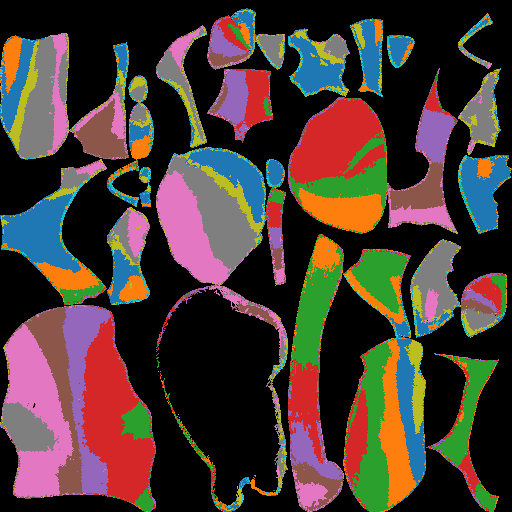

In [198]:
from einops import rearrange

TF.to_pil_image(rearrange(texture, "h w c -> c h w"))

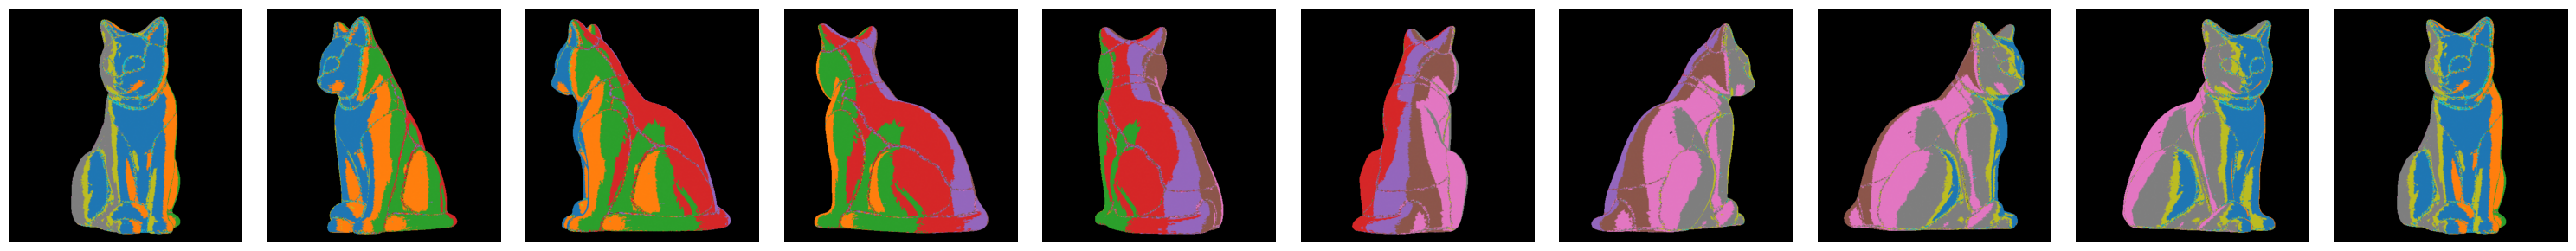

In [183]:
renders = render_texture(frame_meshes, frame_cams, texture, verts_uvs, faces_uvs).cpu()
renders = [TF.to_pil_image(r) for r in renders]
display_ims(renders)

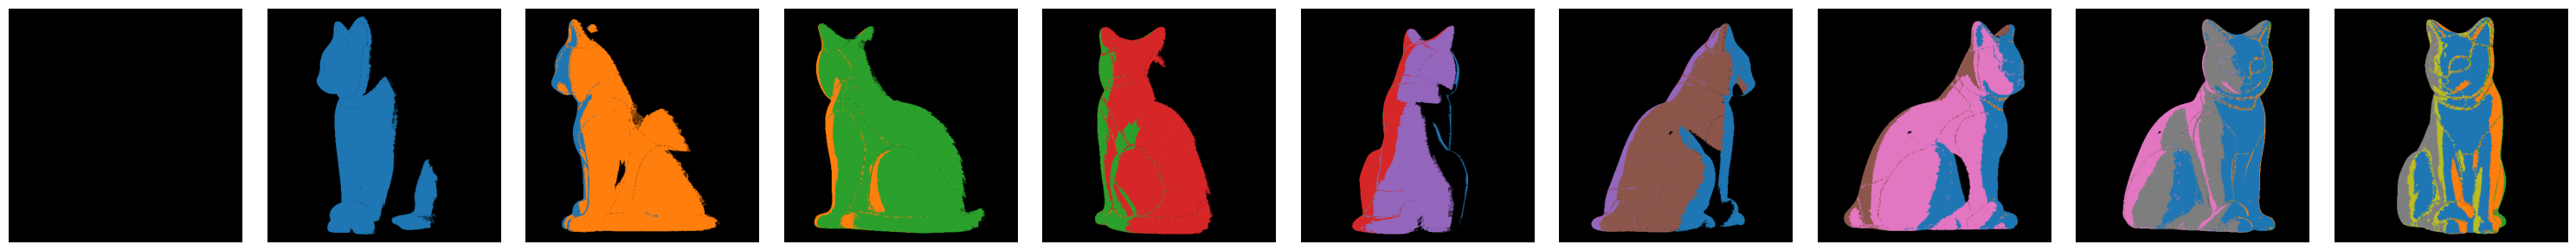

In [199]:
views = logger.key_values("texture_render", "view_i")
renders = [TF.to_pil_image(logger.read("texture_render", view_i=i)) for i in views]
display_ims(renders)